## Asset Pricing with Dividend Growth via Discretization

#### John Stachurski

We aim to compute the price dividend ratio

$$
    V_t = \mathbb E_t
        \left[
            M_{t+1} \frac{D_{t+1}}{D_t}
            (1 + V_{t+1})
        \right]
$$

given the SDF and dividend process.

We consider the case of nonstationary dividends and consumption, where

$$ \ln \frac{D_{t+1}}{D_t} = \mu_d + X_t + \sigma_d \eta_{d, t+1} $$

The shock sequence $\{ \eta_{d,t} \}$ is IID and standard normal.  The state process $\{X_t\}$ obeys

$$ X_{t+1} = \rho X_t + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal. 

Consumption is also nonstationary, obeying

$$ \ln \frac{C_{t+1}}{C_t} = \mu_c + X_t + \sigma_c \eta_{c, t+1} $$

The sequence $\{ \eta_{c,t} \}$ is likewise IID and standard normal.

We use the Lucas SDF

$$ M_{t+1} = \beta \frac{u'(C_{t+1})}{u'(C_t)} $$

The utility function is 

$$ u(c) = \frac{c^{1-\gamma}}{1 - \gamma} $$

Hence

$$ 
    M_{t+1} 
    = \beta \left( \frac{C_{t+1}}{C_t} \right)^{-\gamma} 
    = \beta \exp(-\gamma(  \mu_c + X_t + \sigma_c \eta_{c, t+1} ))
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from scipy.linalg import solve, eigvals

I'm going to use a simple tuple to store parameters.  This is less elegant than some other Python options (look out for Data Classes coming in Python 3.7) but has the advantage that it works cleanly with Numba.

In [2]:
default_params = (0.96,  # β
                  2.0,   # γ
                  0.9,   # ρ
                  0.05,  # σ
                  0.01,  # μ_d
                  0.01,  # σ_d
                  0.05,  # μ_c
                  0.01)  # σ_c

### Discretization 


When we discretize we'll reduce the state process to $n$ states using Tauchen's method.  

Let $Q$ be the resulting stochastic (i.e., Markov) matrix.

In this case (supply details),

$$
    A(x, y) 
    = \beta \exp
        \left(
        -\gamma \mu_c + \mu_d
        + (1 - \gamma) x
        + \frac{\gamma^2 \sigma_c^2 + \sigma_d^2}{2}
        \right)
        Q(x, y)
$$


In [3]:
def price_div_discretized(params, n=20):

    # Unpack parameters
    β, γ, ρ, σ, μ_d, σ_d, μ_c, σ_c = params

    # Discretize state process
    mc = qe.tauchen(ρ, σ, n=n)
    Q = mc.P

    # Compute the matrix A
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            t1 = -γ * μ_c + μ_d + (1 - γ) * mc.state_values[i]
            t2 = (γ**2 * σ_c**2 + σ_d**2) / 2 
            A[i, j] = β * np.exp(t1 + t2) * Q[i, j]

    # Test stability
    rA = np.max(np.abs(eigvals(A)))
    print(f"Computed A with spectral radius {rA}")
    
    # Compute price-dividend ratio
    I = np.identity(n)
    v = solve(I - A, A @ np.ones((n, 1)))
    
    return v, mc.state_values
    


Now let's compute the price dividend ratio at the default parameters and plot it against the state.

In [4]:
v, x = price_div_discretized(default_params)

Computed A with spectral radius 0.9806937813181014


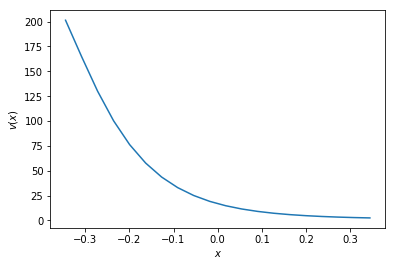

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("$v(x)$")
ax.plot(x, v)
plt.show()